# Notebook for training and testing AI models

## Setup

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from attention import CustomAttention
import json

In [2]:
print(tf.__version__)

2.8.0


In [4]:
# CONSTANTS
RAW_SLEEP_DATA_PATH = ".data/raw_bed_sleep-state.csv"
CLEANED_SLEEP_DATA_PATH = ".data/clean_bed_sleep-state.csv"
SLEEP_DATA_PATH = ".data/sleep_data_simple.csv"
UPDATED_SLEEP_DATA_PATH = ".data/updated_sleep_data.csv"

In [3]:
## Parameters and Hyper-parameters
SLEEP_STAGES = 4

## Import Data

### Cleaning Raw Data

In [59]:
import csv
import datetime
import itertools

In [104]:
datetime.datetime.strptime("2022-04-21T10:18:00+02:00","%Y-%m-%dT%H:%M:%S%z") + datetime.timedelta(minutes=1)

datetime.datetime(2022, 4, 21, 10, 19, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))

In [115]:
def stage_probability(stage, to_test):
    return 1.0 if stage == to_test else 0.0

In [150]:
((start_time - in_bed_time).seconds)/3600

6.833333333333333

In [201]:
cleaned_info = []
date_seen = set()
previous_duration = 60
with open(RAW_SLEEP_DATA_PATH, mode ='r') as raw_file:
    csvFile = csv.reader(raw_file)
    # max_count = 1
    # stuff = set()
    in_bed_time = None
    current_sleep_id = -1
    for index, lines in enumerate(csvFile):
        if index == 0:
            cleaned_info.append([
                "sleep_id",
                "sleep_begin",
                "stage_start",
                "time_since_begin_sec",
                "stage_duration_sec",
                "stage_end", 
                "stage_value",
                "awake_probability",
                "light_probability",
                "deep_probability",
                "rem_probability",
            ])
            continue
        start_time = datetime.datetime.strptime(lines[0],"%Y-%m-%dT%H:%M:%S%z")
        if start_time in date_seen:
            continue
        date_seen.add(start_time)
        if not in_bed_time or in_bed_time > start_time:
            current_sleep_id += 1
            in_bed_time = start_time
        # for duration, stage in enumerate(
        # for offset, (duration, stage) in enumerate(
        #     zip(
        #         # itertools.accumulate(lines[1].strip("[]").split(","), lambda x,y: int(x)+int(y)//60, initial = 0), 
        #         map(int, lines[1].strip("[]").split(","))
        #         map(int, lines[2].strip("[]").split(","))
        #     )
        #         # map(int, lines[2].strip("[]").split(","))
        # ):
        for offset, (duration, stage) in enumerate(zip(map(int, lines[1].strip("[]").split(",")), map(int, lines[2].strip("[]").split(",")))):
            # print(f"{(index, subindex) = }, {duration = }, {stage = }")
            # print(f"{(index, duration) = } {stage = }")
            current_time = start_time + datetime.timedelta(seconds=offset*previous_duration)
            cleaned_info.append([
                current_sleep_id,
                in_bed_time,
                current_time, 
                (current_time - in_bed_time).seconds,
                duration, 
                current_time + datetime.timedelta(seconds=duration), 
                stage,
                stage_probability(0, stage),
                stage_probability(1, stage),
                stage_probability(2, stage),
                stage_probability(3, stage),
            ])
            previous_duration = duration
            # print(f"{(index, subindex) = }, {val = }")
        # print(list())
        # if index >= max_count:
        #     break


In [202]:
with open(CLEANED_SLEEP_DATA_PATH, 'w') as clean_file:
    write = csv.writer(clean_file)
    write.writerows(cleaned_info)
print("Finished Writing Cleaned Data")

Finished Writing Cleaned Data


### Creating DataFrame from clean raw data

In [79]:
# Get the cleaned data
sleep_df_raw = pd.read_csv(CLEANED_SLEEP_DATA_PATH)#, parse_dates=["start", "end"], infer_datetime_format=True)

In [80]:
# Preprocess data: 
#   1. convert to datetime
sleep_df_raw["sleep_begin"] = pd.to_datetime(sleep_df_raw["sleep_begin"], utc=True)
sleep_df_raw["stage_start"] = pd.to_datetime(sleep_df_raw["stage_start"], utc=True)
sleep_df_raw["stage_end"] = pd.to_datetime(sleep_df_raw["stage_end"], utc=True)
#   2. Separate time, hour and minute
#   MAYBE 3. smaller units: int16 or int8 

In [81]:
def get_minute(row, index):
    return row[index].time().minute

def get_hour(row, index):
    return row[index].time().hour

In [82]:
sleep_df_raw["stage_start_hour"] = sleep_df_raw.apply (lambda row: get_hour(row, "stage_start"), axis=1)
sleep_df_raw["stage_start_minute"] = sleep_df_raw.apply (lambda row: get_minute(row, "stage_start"), axis=1)

In [83]:
sleep_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551042 entries, 0 to 551041
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   sleep_id              551042 non-null  int64              
 1   sleep_begin           551042 non-null  datetime64[ns, UTC]
 2   stage_start           551042 non-null  datetime64[ns, UTC]
 3   time_since_begin_sec  551042 non-null  int64              
 4   stage_duration_sec    551042 non-null  int64              
 5   stage_end             551042 non-null  datetime64[ns, UTC]
 6   stage_value           551042 non-null  int64              
 7   awake_probability     551042 non-null  float64            
 8   light_probability     551042 non-null  float64            
 9   deep_probability      551042 non-null  float64            
 10  rem_probability       551042 non-null  float64            
 11  stage_start_hour      551042 non-null  int64        

In [84]:
sleep_df_raw

sleep_id               sleep_begin               stage_start  \
0              0 2022-04-21 08:18:00+00:00 2022-04-21 08:18:00+00:00   
1              0 2022-04-21 08:18:00+00:00 2022-04-21 08:19:00+00:00   
2              0 2022-04-21 08:18:00+00:00 2022-04-21 08:20:00+00:00   
3              0 2022-04-21 08:18:00+00:00 2022-04-21 08:21:00+00:00   
4              0 2022-04-21 08:18:00+00:00 2022-04-21 08:22:00+00:00   
...          ...                       ...                       ...   
551037      1132 2019-02-11 06:11:00+00:00 2019-02-11 13:17:00+00:00   
551038      1132 2019-02-11 06:11:00+00:00 2019-02-11 13:18:00+00:00   
551039      1132 2019-02-11 06:11:00+00:00 2019-02-11 13:19:00+00:00   
551040      1132 2019-02-11 06:11:00+00:00 2019-02-11 13:20:00+00:00   
551041      1132 2019-02-11 06:11:00+00:00 2019-02-11 13:21:00+00:00   

        time_since_begin_sec  stage_duration_sec                 stage_end  \
0                          0                  60 2022-04-21 08:19:00+00:00   
1                         60                  60 2022-04-21 08:20:00+00:00   
2                        120                  60 2022-04-21 08:21:00+00:00   
3                        180                  60 2022-04-21 08:22:00+00:00   
4                        240                  60 2022-04-21 08:23:00+00:00   
...                      ...                 ...                       ...   
551037                 25560                  60 2019-02-11 13:18:00+00:00   
551038                 25620                  60 2019-02-11 13:19:00+00:00   
551039                 25680                  60 2019-02-11 13:20:00+00:00   
551040                 25740                  60 2019-02-11 13:21:00+00:00   
551041                 25800                  60 2019-02-11 13:22:00+00:00   

        stage_value  awake_probability  light_probability  deep_probability  \
0                 0                1.0                0.0               0.0   
1                 0                1.0                0.0               0.0   
2                 0                1.0                0.0               0.0   
3                 0                1.0                0.0               0.0   
4                 0                1.0                0.0               0.0   
...             ...                ...                ...               ...   
551037            1                0.0                1.0               0.0   
551038            1                0.0                1.0               0.0   
551039            1                0.0                1.0               0.0   
551040            1                0.0                1.0               0.0   
551041            1                0.0                1.0               0.0   

        rem_probability  stage_start_hour  stage_start_minute  
0                   0.0                 8                  18  
1                   0.0                 8                  19  
2                   0.0                 8                  20  
3                   0.0                 8                  21  
4                   0.0                 8                  22  
...                 ...               ...                 ...  
551037              0.0                13                  17  
551038              0.0                13                  18  
551039              0.0                13                  19  
551040              0.0                13                  20  
551041              0.0                13                  21  

[551042 rows x 13 columns]

In [37]:
sleep_data = sleep_df_raw[["sleep_id", "stage_start_hour", "stage_start_minute", "awake_probability", "rem_probability","light_probability", "deep_probability"]]
sleep_data.insert(loc=1, column="minutes_since_begin" , value= sleep_df_raw["time_since_begin_sec"]//60)

In [32]:
print(sleep_data.head())
print(sleep_data.info())

   sleep_id  minutes_since_begin  stage_start_hour  stage_start_minute  \
0         0                    0                 8                  18   
1         0                    1                 8                  19   
2         0                    2                 8                  20   
3         0                    3                 8                  21   
4         0                    4                 8                  22   

   awake_probability  rem_probability  light_probability  deep_probability  
0                1.0              0.0                0.0               0.0  
1                1.0              0.0                0.0               0.0  
2                1.0              0.0                0.0               0.0  
3                1.0              0.0                0.0               0.0  
4                1.0              0.0                0.0               0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551042 entries, 0 to 551041
Data columns (t

In [38]:
sleep_data.to_csv(".data/sleep_data_simple.csv", index=False, index_label=False)

## Model Development

### Setup

In [11]:
TEST_SIZE = 365//2
VALIDATION_SIZE = 365

BATCH_SIZE = 64
INPUT_TIME_STEP = 5 # in minutes
INPUT_FEATURES_SIZE = 7
MAX_EPOCHS = 20

In [12]:
SAMPLE_COUNT = 1000
#   A R L D
# A
# R
# L
# D
CONFUSION_MATRIX = np.array(
    [
        [66.2, 5.0, 22.5, 6.2],
        [1.6, 60.7, 33.0, 4.7],
        [3.8, 22.3, 55.4, 18.5],
        [0.0, 1.3, 26.7, 72.0],
    ]
)/100

### Import Data

In [14]:
# sleep_data = pd.read_csv(SLEEP_DATA_PATH)
sleep_data = pd.read_csv(UPDATED_SLEEP_DATA_PATH)

In [15]:
sleep_data

sleep_id  minutes_since_begin  stage_start_hour  stage_start_minute  \
0            0.0                  0.0               8.0                18.0   
1            0.0                  1.0               8.0                19.0   
2            0.0                  2.0               8.0                20.0   
3            0.0                  3.0               8.0                21.0   
4            0.0                  4.0               8.0                22.0   
...          ...                  ...               ...                 ...   
551037    1132.0                426.0              13.0                17.0   
551038    1132.0                427.0              13.0                18.0   
551039    1132.0                428.0              13.0                19.0   
551040    1132.0                429.0              13.0                20.0   
551041    1132.0                430.0              13.0                21.0   

        awake_probability_noisy  rem_probability_noisy  \
0                         0.680                  0.057   
1                         0.652                  0.060   
2                         0.672                  0.059   
3                         0.645                  0.056   
4                         0.644                  0.054   
...                         ...                    ...   
551037                    0.041                  0.193   
551038                    0.027                  0.209   
551039                    0.032                  0.220   
551040                    0.036                  0.256   
551041                    0.033                  0.205   

        light_probability_noisy  deep_probability_noisy  \
0                         0.200                   0.063   
1                         0.224                   0.064   
2                         0.209                   0.060   
3                         0.235                   0.064   
4                         0.244                   0.058   
...                         ...                     ...   
551037                    0.576                   0.190   
551038                    0.563                   0.201   
551039                    0.574                   0.174   
551040                    0.530                   0.178   
551041                    0.571                   0.191   

        awake_probability_original  rem_probability_original  \
0                              1.0                       0.0   
1                              1.0                       0.0   
2                              1.0                       0.0   
3                              1.0                       0.0   
4                              1.0                       0.0   
...                            ...                       ...   
551037                         0.0                       0.0   
551038                         0.0                       0.0   
551039                         0.0                       0.0   
551040                         0.0                       0.0   
551041                         0.0                       0.0   

        light_probability_original  deep_probability_original  
0                              0.0                        0.0  
1                              0.0                        0.0  
2                              0.0                        0.0  
3                              0.0                        0.0  
4                              0.0                        0.0  
...                            ...                        ...  
551037                         1.0                        0.0  
551038                         1.0                        0.0  
551039                         1.0                        0.0  
551040                         1.0                        0.0  
551041                         1.0                        0.0  

[551042 rows x 12 columns]

### Create Randmonizations

In [49]:
def softmax(arr):
    val = np.exp(arr)
    return val / sum(val)

In [133]:
def noisy_randomizer(confusion_matrix_index: int, sample_count: int = SAMPLE_COUNT, confusion_matrix = CONFUSION_MATRIX):
    return softmax(np.random.multinomial(sample_count, confusion_matrix[confusion_matrix_index], size=1)[0])

In [173]:
def create_updated(dataframe):
    dataframe_array = dataframe.to_numpy()
    updated_probs = np.array(list(map(noisy_randomizer, np.argmax(dataframe_array[:, -4:], axis=1))))
    columns_tmp = dataframe.columns.to_list() 
    noisy_column = list(map(lambda name: f"{name}_noisy", columns_tmp[-4:]))
    og_column = list(map(lambda name: f"{name}_original", columns_tmp[-4:]))
    return pd.DataFrame(np.concatenate([dataframe_array[:, :-4], updated_probs, dataframe_array[:, -4:]], axis=1), columns = columns_tmp[:-4]+noisy_column+og_column)

In [174]:
sleep_data_updated = create_updated(sleep_data)

In [176]:
sleep_data_updated.to_csv(UPDATED_SLEEP_DATA_PATH, index=False, index_label=False)

### Helper functions and class

In [16]:
def training_test_split_by_unique_index(data, index: str, test_size: int = 10):
    test_ids = np.random.choice(data[index].unique(), size = test_size, replace=False)
    return data[~data[index].isin(test_ids)], data[data[index].isin(test_ids)]

In [17]:
# Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series
class WindowGenerator():
    def __init__(self, data, index: str = "sleep_id", input_width: int = INPUT_TIME_STEP, validation_size: int = VALIDATION_SIZE, test_size: int = TEST_SIZE, input_feature_slice: slice = slice(1,-4), label_feature_slice: slice = slice(-4,100), generate_data_now: bool = True):
        # Partition data
        self.training, self.testing = training_test_split_by_unique_index(data, index, test_size)
        self.training, self.validation = training_test_split_by_unique_index(self.training, index, validation_size)

        # Window paramters
        self.input_width = input_width
        self.label_width = 1
        self.shift = 1

        self.total_window_size = self.input_width + self.shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.input_feature_slice = input_feature_slice
        self.label_feature_slice = label_feature_slice

        self.sample_ds = self.make_dataset(data[data[index] == 0])

        if generate_data_now:
            self.training_ds = self.make_dataset(self.training, index)
            self.validation_ds = self.make_dataset(self.validation, index)
            self.testing_ds = self.make_dataset(self.testing, index)


    def __repr__(self):
        return "WindowGenerator:\n\t" +'\n\t'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
        ])

    def split_window(self, features):
        inputs = features[:, self.input_slice, self.input_feature_slice]
        inputs.set_shape([None, self.input_width, None])
        
        labels = tf.squeeze(features[:, self.labels_slice, self.label_feature_slice])
        # labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data, index_group: str = "sleep_id", sort_by: str = "minutes_since_begin"):
        ds_all = None
        for i_group in data[index_group].unique():
            subset_data = np.array(data[data[index_group] == i_group].sort_values(by=[sort_by]), dtype=np.float32)
            ds = tf.keras.utils.timeseries_dataset_from_array(
                data=subset_data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=1,
                shuffle=False,
                batch_size=BATCH_SIZE,)
            ds_all = ds if ds_all is None else ds_all.concatenate(ds)
        ds_all = ds_all.map(self.split_window)

        return ds_all

### General Model Helper

In [28]:
# Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series#linear_model
def compile_and_fit(model, window: WindowGenerator, loss = tf.losses.CategoricalCrossentropy(from_logits=True), optimizer = tf.optimizers.Adam(), metrics = None, early_stop: bool = True, patience:int = 2, baseline = None, epochs: int = MAX_EPOCHS):
    if metrics is None:
        metrics = [tf.keras.metrics.CategoricalCrossentropy(from_logits=True), tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.CategoricalHinge()]

    callbacks = []
    if early_stop:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            baseline = baseline,
            mode='min'
        )
        callbacks.append(early_stopping)

    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
    )

    return model.fit(window.training_ds, epochs=epochs, validation_data=window.validation_ds, callbacks=callbacks)

### Experimenting

In [19]:
# USE SUBSET OF DATA FOR EXPERIMENTING
sleep_data_sub = sleep_data[sleep_data.sleep_id < 3]

In [20]:
wg_sub = WindowGenerator(sleep_data_sub,validation_size=1, test_size=1)

In [24]:
for ele in wg_sub.training_ds.as_numpy_iterator():
    print(f"{ele[0][0] = }")

ele[0][0] = array([[ 0.,  7., 40.,  1.,  0.,  0.,  0.],
       [ 1.,  7., 41.,  1.,  0.,  0.,  0.],
       [ 2.,  7., 42.,  1.,  0.,  0.,  0.],
       [ 3.,  7., 43.,  1.,  0.,  0.,  0.],
       [ 4.,  7., 44.,  1.,  0.,  0.,  0.],
       [ 5.,  7., 45.,  1.,  0.,  0.,  0.],
       [ 6.,  7., 46.,  1.,  0.,  0.,  0.],
       [ 7.,  7., 47.,  1.,  0.,  0.,  0.],
       [ 8.,  7., 48.,  1.,  0.,  0.,  0.],
       [ 9.,  7., 49.,  1.,  0.,  0.,  0.]], dtype=float32)
ele[0][0] = array([[64.,  8., 44.,  0.,  0.,  1.,  0.],
       [65.,  8., 45.,  0.,  0.,  1.,  0.],
       [66.,  8., 46.,  0.,  0.,  1.,  0.],
       [67.,  8., 47.,  0.,  0.,  1.,  0.],
       [68.,  8., 48.,  0.,  0.,  1.,  0.],
       [69.,  8., 49.,  0.,  0.,  1.,  0.],
       [70.,  8., 50.,  0.,  0.,  1.,  0.],
       [71.,  8., 51.,  0.,  0.,  1.,  0.],
       [72.,  8., 52.,  0.,  0.,  1.,  0.],
       [73.,  8., 53.,  0.,  0.,  1.,  0.]], dtype=float32)
ele[0][0] = array([[128.,   9.,  48.,   0.,   0.,   1.,   0.],
 

In [13]:
BASELINE_UNITS = 32
baseline_model = keras.Sequential(
    [
        layers.Input(shape=(INPUT_TIME_STEP, INPUT_FEATURES_SIZE)),
        layers.Dense(BASELINE_UNITS),
        # layers.Dense(BASELINE_UNITS),
        # layers.Dense(BASELINE_UNITS),
        layers.Flatten(),
        layers.Dense(SLEEP_STAGES),
    ]
)
baseline_model.build()
print(baseline_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5, 32)             256       
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 644       
                                                                 
Total params: 900
Trainable params: 900
Non-trainable params: 0
_________________________________________________________________
None


2022-05-15 17:27:23.605130: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
baseline_history = compile_and_fit(baseline_model, wg_sub)

Epoch 1/20
8955/8955 [==============================] - 60s 7ms/step - loss: 2.7762 - categorical_crossentropy: 2.7745 - categorical_accuracy: 0.7612 - categorical_hinge: 15.1798 - val_loss: 0.2711 - val_categorical_crossentropy: 0.2710 - val_categorical_accuracy: 0.9546 - val_categorical_hinge: 5.1404
Epoch 2/20
8955/8955 [==============================] - 60s 7ms/step - loss: 0.3110 - categorical_crossentropy: 0.3111 - categorical_accuracy: 0.9418 - categorical_hinge: 1.5468 - val_loss: 0.2106 - val_categorical_crossentropy: 0.2105 - val_categorical_accuracy: 0.9583 - val_categorical_hinge: 0.3215
Epoch 3/20
8955/8955 [==============================] - 60s 7ms/step - loss: 0.2253 - categorical_crossentropy: 0.2254 - categorical_accuracy: 0.9551 - categorical_hinge: 0.2726 - val_loss: 0.2068 - val_categorical_crossentropy: 0.2067 - val_categorical_accuracy: 0.9582 - val_categorical_hinge: 0.3656
Epoch 4/20
8955/8955 [==============================] - 63s 7ms/step - loss: 0.2059 - cate

In [29]:
baseline_history.history.keys()

dict_keys(['loss', 'categorical_crossentropy', 'categorical_accuracy', 'categorical_hinge', 'val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy', 'val_categorical_hinge'])

In [32]:
save_history(baseline_history.history, ".history/baseline.csv")

In [31]:
def save_history(history, file_name: str = "history.csv"):
    pd.DataFrame.from_dict(history).to_csv(file_name, index=False)

In [33]:
baseline_model.save(".model/baseline")

2022-05-11 15:02:03.185843: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: .model/baseline/assets


### Data Prep

All inputs follow: (batch_size, timesteps, input_dim)

In [19]:
wg = WindowGenerator(sleep_data)
wg

2022-05-12 14:18:02.248350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


WindowGenerator:
	Total window size: 6
	Input indices: [0 1 2 3 4]
	Label indices: [5]

In [20]:
len(wg.training_ds)

4682

In [27]:
for ele in wg.sample_ds.take(1):
    print(f"{ele[0].numpy()[0] = }")
    print(f"{ele[1].numpy()[0] = }")

ele[0].numpy()[0] = array([[ 0.   ,  8.   , 18.   ,  0.68 ,  0.057,  0.2  ,  0.063],
       [ 1.   ,  8.   , 19.   ,  0.652,  0.06 ,  0.224,  0.064],
       [ 2.   ,  8.   , 20.   ,  0.672,  0.059,  0.209,  0.06 ],
       [ 3.   ,  8.   , 21.   ,  0.645,  0.056,  0.235,  0.064],
       [ 4.   ,  8.   , 22.   ,  0.644,  0.054,  0.244,  0.058]],
      dtype=float32)
ele[1].numpy()[0] = array([1., 0., 0., 0.], dtype=float32)


### Model 1: LSTM

In [17]:
# Hyper-parameters
LSTM_UNITS = 16
LSTM_LEARNING_RATE = 0.0001

In [18]:
# Model Definition
lstm_model = keras.Sequential()
lstm_model.add(layers.Input(shape=(INPUT_TIME_STEP, INPUT_FEATURES_SIZE)))
# lstm_model.add(layers.LSTM(LSTM_UNITS, stateful=False, return_sequences=True))
# lstm_model.add(layers.LSTM(LSTM_UNITS, stateful=False, return_sequences=True))
lstm_model.add(layers.LSTM(LSTM_UNITS, stateful=False, return_sequences=False))
lstm_model.add(layers.Dense(SLEEP_STAGES))
lstm_model.build()
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1536      
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 1,604
Trainable params: 1,604
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# Model Training
lstm_loss = tf.losses.CategoricalCrossentropy(from_logits=True)
lstm_optm = tf.optimizers.Adam(learning_rate=LSTM_LEARNING_RATE)
lstm_metrics = [tf.keras.metrics.CategoricalCrossentropy(from_logits=True), tf.keras.metrics.BinaryCrossentropy(from_logits=True),tf.keras.metrics.Accuracy()]

In [39]:
lstm_history = compile_and_fit(model=lstm_model, window=wg, epochs=1)

9647/9647 [==============================] - 88s 9ms/step - loss: 0.6389 - categorical_crossentropy: 0.6388 - categorical_accuracy: 0.7669 - categorical_hinge: 0.5620 - val_loss: 0.2218 - val_categorical_crossentropy: 0.2217 - val_categorical_accuracy: 0.9551 - val_categorical_hinge: 0.2163


### Model 2: GRU

In [19]:
# Hyper-paramters
GRU_UNITS = 16

In [20]:
gru_model = keras.Sequential()
gru_model.add(layers.Input(shape=(INPUT_TIME_STEP, INPUT_FEATURES_SIZE)))
gru_model.add(layers.GRU(GRU_UNITS))
gru_model.add(layers.Dense(SLEEP_STAGES))
gru_model.build()
print(gru_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                1200      
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 1,268
Trainable params: 1,268
Non-trainable params: 0
_________________________________________________________________
None


In [91]:
gru_history = compile_and_fit(model=gru_model, window=wg)

KeyboardInterrupt: 

### Model 3: Attention Mechanism

In [21]:
ATTENTION_UNITS = 32

In [22]:
am_model = keras.Sequential()
am_model.add(layers.Input(shape=(INPUT_TIME_STEP, INPUT_FEATURES_SIZE)))
am_model.add(CustomAttention(ATTENTION_UNITS))
am_model.add(layers.Dense(SLEEP_STAGES))
am_model.build()
print(am_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_attention (CustomAtt  (None, 32)               497       
 ention)                                                         
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 629
Trainable params: 629
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
am_model.load_weights("TEST")

In [38]:
am_history = compile_and_fit(model=am_model, window=wg)

Epoch 1/20
4682/4682 [==============================] - 67s 14ms/step - loss: 0.9233 - categorical_crossentropy: 0.9233 - categorical_accuracy: 0.5880 - categorical_hinge: 0.9024 - val_loss: 0.4996 - val_categorical_crossentropy: 0.4996 - val_categorical_accuracy: 0.9040 - val_categorical_hinge: 0.3196
Epoch 2/20
4682/4682 [==============================] - 56s 12ms/step - loss: 0.3929 - categorical_crossentropy: 0.3929 - categorical_accuracy: 0.8920 - categorical_hinge: 0.3280 - val_loss: 0.4142 - val_categorical_crossentropy: 0.4142 - val_categorical_accuracy: 0.8625 - val_categorical_hinge: 0.3925
Epoch 3/20
4682/4682 [==============================] - 76s 16ms/step - loss: 0.3686 - categorical_crossentropy: 0.3686 - categorical_accuracy: 0.8872 - categorical_hinge: 0.3478 - val_loss: 0.2700 - val_categorical_crossentropy: 0.2700 - val_categorical_accuracy: 0.9252 - val_categorical_hinge: 0.2614
Epoch 4/20
4682/4682 [==============================] - 72s 15ms/step - loss: 0.3373 - c

In [42]:
results = am_model.evaluate(wg.testing_ds)

1450/1450 [==============================] - 13s 4ms/step - loss: 0.2333 - categorical_crossentropy: 0.2333 - categorical_accuracy: 0.9552 - categorical_hinge: 0.2243


In [46]:
answer = am_model.predict(np.array(
    [[
        [ 150.,  10., 20.,  0.5,  0.1,  0.,  0.4],
        [ 151.,  10., 21.,  0.5,  0.2,  0.,  0.3],
        [ 152.,  10., 22.,  0.5,  0.3,  0.,  0.2],
        [ 153.,  10., 23.,  0.5,  0.4,  0.,  0.1],
        [ 154.,  10., 24.,  0.2,  0.1,  0.7,  0.],
    ]]
))
norm = np.linalg.norm(answer)
normalized_answer = answer/norm
normalized_answer

array([[-0.4693893 , -0.7194527 ,  0.18727879, -0.47643274]],
      dtype=float32)

In [52]:
answer, softmax(answer[0])

(array([[-2.8096135, -4.3064127,  1.1209906, -2.8517733]], dtype=float32),
 array([0.0188252 , 0.00421393, 0.95891285, 0.01804803], dtype=float32))

In [41]:
pd.DataFrame.from_dict(am_history.history).to_csv(f"{HISTORY_DIR}/am_noisy_run_hist.csv", index=False)

NameError: name 'HISTORY_DIR' is not defined

In [46]:
help(am_model.save_weights)

Help on method save_weights in module keras.engine.training:

save_weights(filepath, overwrite=True, save_format=None, options=None) method of keras.engine.sequential.Sequential instance
    Saves all layer weights.
    
    Either saves in HDF5 or in TensorFlow format based on the `save_format`
    argument.
    
    When saving in HDF5 format, the weight file has:
      - `layer_names` (attribute), a list of strings
          (ordered names of model layers).
      - For every layer, a `group` named `layer.name`
          - For every such layer group, a group attribute `weight_names`,
              a list of strings
              (ordered names of weights tensor of the layer).
          - For every weight in the layer, a dataset
              storing the weight value, named after the weight tensor.
    
    When saving in TensorFlow format, all objects referenced by the network are
    saved in the same format as `tf.train.Checkpoint`, including any `Layer`
    instances or `Optimizer

In [136]:
am_model.save(f"{MODEL_DIR}/attention")

2022-05-12 18:50:44.183309: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: .model/attention/assets


INFO:tensorflow:Assets written to: .model/attention/assets


### Model Head-to-Head testing

In [5]:
HISTORY_DIR = ".history"
MODEL_DIR = ".model"

In [6]:
base_history = pd.read_csv(f"{HISTORY_DIR}/baseline.csv")
lstm_history = pd.read_csv(f"{HISTORY_DIR}/lstm.csv")
gru_history = pd.read_csv(f"{HISTORY_DIR}/gru.csv")
attn_history = pd.read_csv(f"{HISTORY_DIR}/attention.csv")
history_columns = ["categorical_crossentropy", "val_categorical_crossentropy"] # "categorical_accuracy"

<AxesSubplot:title={'center':'Attention Model Log-Loss'}>

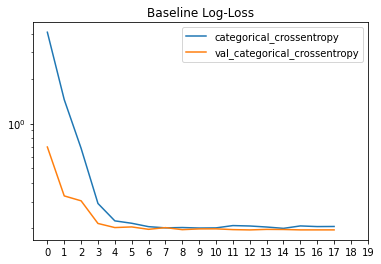

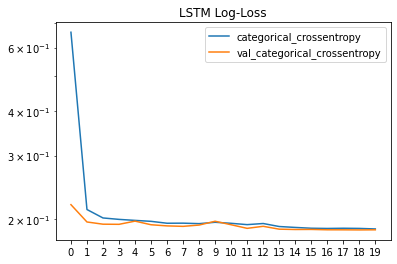

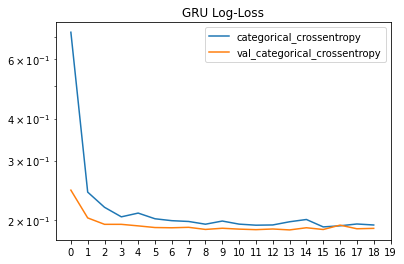

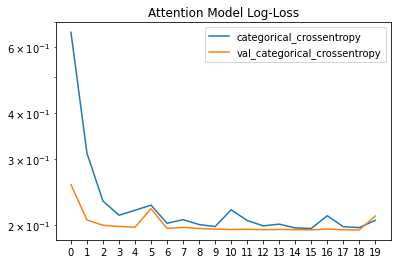

In [9]:
base_history[history_columns].plot(title="Baseline Log-Loss", logy=True, xticks=range(20))
lstm_history[history_columns].plot(title="LSTM Log-Loss", logy=True, xticks=range(20))
gru_history[history_columns].plot(title="GRU Log-Loss", logy=True, xticks=range(20))
attn_history[history_columns].plot(title="Attention Model Log-Loss", logy=True, xticks=range(20))

In [28]:
base_model = tf.keras.models.load_model(f"{MODEL_DIR}/baseline")
lstm_model = tf.keras.models.load_model(f"{MODEL_DIR}/lstm")
gru_model = tf.keras.models.load_model(f"{MODEL_DIR}/gru")

In [29]:
attn_model = tf.keras.models.load_model(f"{MODEL_DIR}/attention")

RuntimeError: Unable to restore object of class 'Attention' likely due to name conflict with built-in Keras class '<class 'keras.layers.dense_attention.Attention'>'. To override the built-in Keras definition of the object, decorate your class with `@keras.utils.register_keras_serializable` and include that file in your program, or pass your class in a `keras.utils.CustomObjectScope` that wraps this load call.

In [ ]:
def model_time():
    pass

## Model Conversion

In [139]:
import tensorflow as tf

In [140]:
model = tf.keras.models.load_model(f"{MODEL_DIR}/attention")

In [141]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_attention_1 (CustomA  (None, 32)               497       
 ttention)                                                       
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 629
Trainable params: 629
Non-trainable params: 0
_________________________________________________________________


In [142]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(f'{MODEL_DIR}/attention_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/bm/yzlckp6x6vl9_bm329kms7680000gp/T/tmpvx4lpz4_/assets


INFO:tensorflow:Assets written to: /var/folders/bm/yzlckp6x6vl9_bm329kms7680000gp/T/tmpvx4lpz4_/assets
2022-05-12 20:51:22.624411: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-12 20:51:22.624442: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-12 20:51:22.635394: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/bm/yzlckp6x6vl9_bm329kms7680000gp/T/tmpvx4lpz4_
2022-05-12 20:51:22.637424: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-12 20:51:22.637987: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/bm/yzlckp6x6vl9_bm329kms7680000gp/T/tmpvx4lpz4_
2022-05-12 20:51:22.648488: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-12 20:51:22.709625: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

# Scratch

In [100]:
from collections import deque
import datetime

In [96]:
d = deque(maxlen=10)

In [97]:
while len(d) < d.maxlen:
    d.append(np.array([1,2,3, 4.0]))

In [87]:
d.append(5)

In [98]:
np.array(d)

array([[1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.]])

In [115]:
curr_time = datetime.datetime.utcnow()

In [118]:
curr_time.hour

23

In [135]:
datetime.datetime.now() < datetime.datetime.now() - datetime.timedelta(minutes=30)

False

In [121]:
np.concatenate([[120, 15, 2], np.array([0.25,0.25,0.25,0.25])]) -

array([120.  ,  15.  ,   2.  ,   0.25,   0.25,   0.25,   0.25])

In [138]:
softmax(np.array([0.25,0.25,0.25,0.25]) - np.array([0.25,0.95,1.0,1.0]))

array([0.40961474, 0.20340866, 0.1934883 , 0.1934883 ])